#### Import libraries and packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import plotly.express as px


#### Import dataset

In [2]:
df = pd.read_csv("C:\\Users\\Admin\\Desktop\\BME 3\\BME-3\\dataset\\top_drug_hanoi_dataset.csv", parse_dates=True,index_col=0)

#### Create a new Timestamp column for time series forecasting

In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['quantity'].values.reshape(-1, 1)
df.head()

df

,quantity,Timestamp
time,,
2018-10-04,30,1.538611e+09
2018-10-18,70,1.539821e+09
2018-10-23,30,1.540253e+09
2018-10-23,10,1.540253e+09
2018-10-24,50,1.540339e+09
...,...,...
2022-07-07,50,1.657152e+09
2022-07-08,10,1.657238e+09
2022-07-09,10,1.657325e+09


#### Plotting line chart

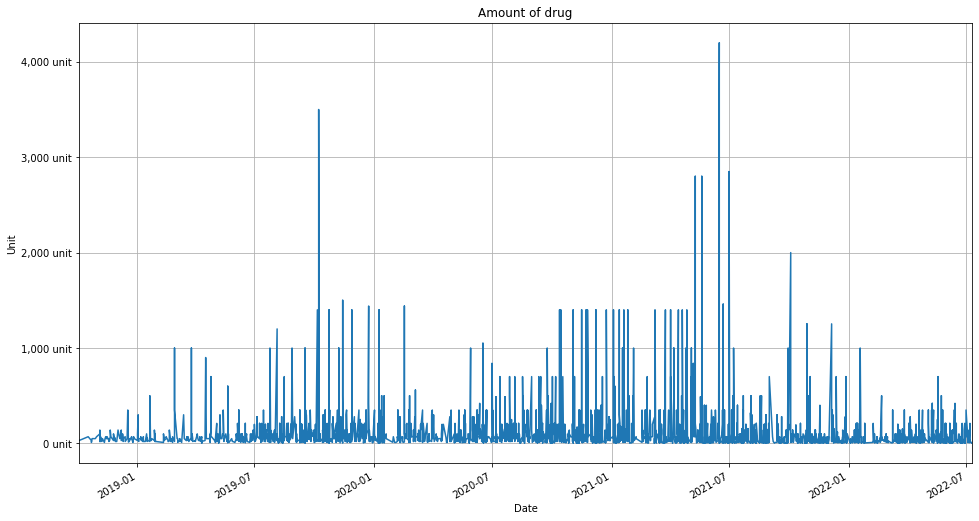

In [4]:
formatter = ticker.StrMethodFormatter('{x:,.0f} unit')

title = 'Amount of drug'
ylabel = 'Unit'
xlabel = 'Date'

ax = df['quantity'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

#### Normalizing / scaling data to facilitate model building

In [5]:
sc = StandardScaler()

df_scaled = df.copy()
df_scaled['quantity'] = sc.fit_transform(df_open)
df_scaled

,quantity,Timestamp
time,,
2018-10-04,-0.322800,1.538611e+09
2018-10-18,-0.143205,1.539821e+09
2018-10-23,-0.322800,1.540253e+09
2018-10-23,-0.412597,1.540253e+09
2018-10-24,-0.233002,1.540339e+09
...,...,...
2022-07-07,-0.233002,1.657152e+09
2022-07-08,-0.412597,1.657238e+09
2022-07-09,-0.412597,1.657325e+09


In [6]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['quantity'] = y_scaled
df_scaled.head()

,Timestamp,quantity
time,,
2018-10-04,-2.214024,-0.322800
2018-10-18,-2.175483,-0.143205
2018-10-23,-2.161719,-0.322800
2018-10-23,-2.161719,-0.412597
2018-10-24,-2.158966,-0.233002


#### Split data for training and testing ( 8-2 )

In [7]:
interrupt = int(len(df_scaled) * .8)

train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)

(2489, 2)
(623, 2)


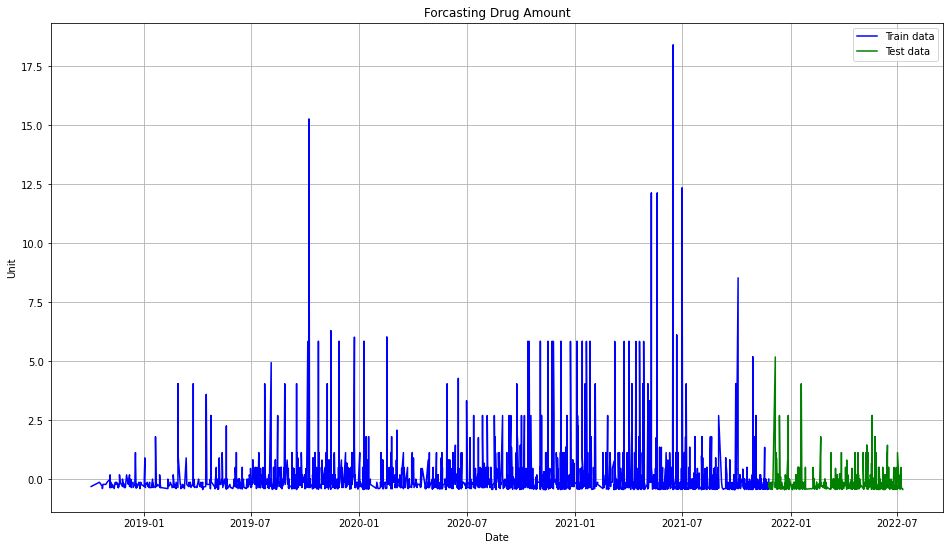

In [8]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Unit')
plt.xlabel('Date')
plt.title("Forcasting Drug Amount")
plt.plot(train_data['quantity'], 'blue', label='Train data')
plt.plot(test_data['quantity'], 'green', label='Test data')
plt.legend()

#### Determine the independent variable (X) and the dependent variable (y)

In [9]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['quantity'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['quantity'].values.reshape(-1, 1)

# Building model 

In [10]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 24%|██▍       | 10/42 [00:00<00:01, 16.88it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 67%|██████▋   | 28/42 [00:04<00:02,  5.99it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(2489, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [05:24<00:00,  7.73s/it]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
QuantileRegressor                           -0.01      -0.01   0.48   
LinearSVR                                   -0.01      -0.01   0.48   
GradientBoostingRegressor                   -0.01      -0.01   0.48   
NuSVR                                       -0.02      -0.02   0.48   
XGBRegressor                                -0.02      -0.02   0.48   
RandomForestRegressor                       -0.03      -0.03   0.48   
HuberRegressor                              -0.03      -0.03   0.48   
KNeighborsRegressor                         -0.03      -0.03   0.48   
DecisionTreeRegressor                       -0.05      -0.05   0.49   
ExtraTreeRegressor                          -0.05      -0.05   0.49   
ExtraTreesRegressor                         -0.05      -0.05   0.49   
HistGradientBoostingRegressor               -0.06      -0.06   0.49   
Baggin

In [11]:
top_10= models.sort_values(by='Adjusted R-Squared', ascending=False).head(12)
print(top_10)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
QuantileRegressor                           -0.01      -0.01  0.48      317.30
LinearSVR                                   -0.01      -0.01  0.48        0.01
GradientBoostingRegressor                   -0.01      -0.01  0.48        0.46
NuSVR                                       -0.02      -0.02  0.48        0.42
XGBRegressor                                -0.02      -0.02  0.48        1.51
RandomForestRegressor                       -0.03      -0.03  0.48        0.56
HuberRegressor                              -0.03      -0.03  0.48        0.02
KNeighborsRegressor                         -0.03      -0.03  0.48        0.02
ExtraTreesRegressor                         -0.05      -0.05  0.49        0.27
ExtraTreeRegressor                          -0.05      -0.05  0.49        0.01
DecisionTreeRegressor                       -0.05   

### visualization of autoML

In [21]:
line = px.line(data_frame= models ,y =["Adjusted R-Squared"] , markers = True)
line.update_xaxes(title="Model",
                rangeslider_visible = False)
line.update_yaxes(title = "Adjusted R-Squared")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Ad R^2 vs Model',
        # 'y':0.94,
        # 'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

# Hyperparameter turning (in future)

#### Try with Linear Regression (temp)

In [12]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)
pred

array([[0.06034328],
       [0.06034328],
       [0.06034328],
       [0.06037392],
       [0.06037392],
       [0.06040456],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06046583],
       [0.06049647],
       [0.06049647],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.0605271 ],
       [0.06055774],
       [0.06068028],
       [0.06068028],
       [0.06068028],
       [0.06071092],
       [0.06071092],
       [0.06071092],
       [0.06071092],
       [0.06071092],
       [0.06074156],
       [0.06074156],
       [0.06074156],
       [0.06077219],
       [0.06077219],
       [0.06080283],
       [0.06080283],
       [0.06080283],
       [0.06080283],
       [0.06083346],
       [0.060

#### Transform back to original form

In [13]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))


#### Graph the test set and the prediction results

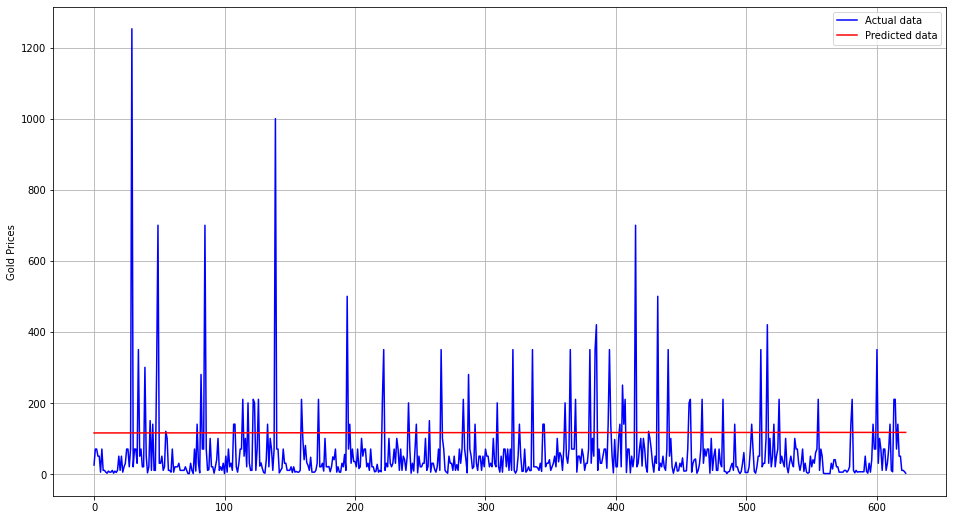

In [22]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
plt.legend()

#### Model Evaluation

In [23]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred) 
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse) 
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 92.26
MAPE: 924.45%
MSE: 14205.28
RMSE: 119.19
R2: -0.28


In [24]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
time,,,
2021-11-25,25.00,115.34,-90.34
2021-11-25,70.00,115.34,-45.34
2021-11-25,70.00,115.34,-45.34
2021-11-26,50.00,115.34,-65.34
2021-11-26,50.00,115.34,-65.34
...,...,...,...
2022-07-07,50.00,116.86,-66.86
2022-07-08,10.00,116.87,-106.87
2022-07-09,10.00,116.88,-106.88
